## Linear Regression using PyMC

In [1]:
#Importing the necessary Python packages
#Bayesian Package
import pymc as pm
#Data Manipulation packages
import numpy as np
import pandas as pd
#Display package
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Importing the dataset
#Outcome variable: mpg, Input variables: weight, acceleration
autodata = pd.read_csv("auto-mpg.csv")
autodata.columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name']

In [3]:
def linear_setup(df, ind_cols, dep_col):
    '''
    Inputs: pandas Data Frame, list of independent features, outcome var
    Output: PyMC Model
    '''

    # Non-informative priors for parameters- intercept and error
    b0 = pm.Normal('b0', 0, 0.0001)
    err = pm.Normal('err', 0, 0.0001)

    # initialize NumPy arrays for b and x with same size as no of covariates
    b = np.empty(len(ind_cols), dtype=object)
    x = np.empty(len(ind_cols), dtype=object)

    # Non-informative priors for each coefficient
    for i in range(len(b)):
        b[i] = pm.Normal('b' + str(i + 1), 0, 0.0001)

    # Equating x with normal distribution for each data point
    for i, col in enumerate(ind_cols):
        x[i] = pm.Normal('x' + str(i + 1), 0, 1, value=np.array(df[col]), observed=True)

    # For deterministic equations, need to define the function in this format
    # .dot() for 2D array (i.e., matrix) multiplication since its multi-variable regression
    @pm.deterministic
    def y_pred(b0=b0, b=b, x=x):
        return b0 + b.dot(x)

    # Modeling observed y values
    y = pm.Normal('y', y_pred, err, value=np.array(df[dep_col]), observed=True)

    # Returning the required model
    return pm.Model([b0, pm.Container(b), err, pm.Container(x), y, y_pred])


In [4]:
# Function call to Multiple Linear Regression
test_model = linear_setup(autodata, ['weight', 'acceleration'], 'mpg')

# Simulating using pm.MCMC -> Takes the model as a parameter
# Prepare the model
mcmc = pm.MCMC(test_model)

#Run the model. Accepts (no of total sample, no of samples burnt) as an argument
mcmc.sample(100000, 30000)

C:\Users\suman\Anaconda3\envs\py36\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 100000 of 100000 complete in 31.3 sec

In [5]:
# Values for each variable can obtained using trace command
b_intercept_posterior = mcmc.trace('b0')[:]
b_weight_posterior = mcmc.trace('b1')[:]
b_accelerate_posterior = mcmc.trace('b2')[:]

print('Intercept: ' + str(np.mean(b_intercept_posterior)))
print('Weight Coefficient: ' + str(np.mean(b_weight_posterior)))
print('Acceleration Coefficient: ' + str(np.mean(b_accelerate_posterior)))

Intercept: 41.4215393827
Weight Coefficient: -0.00733455257296
Acceleration Coefficient: 0.249259738815


C:\Users\suman\Anaconda3\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


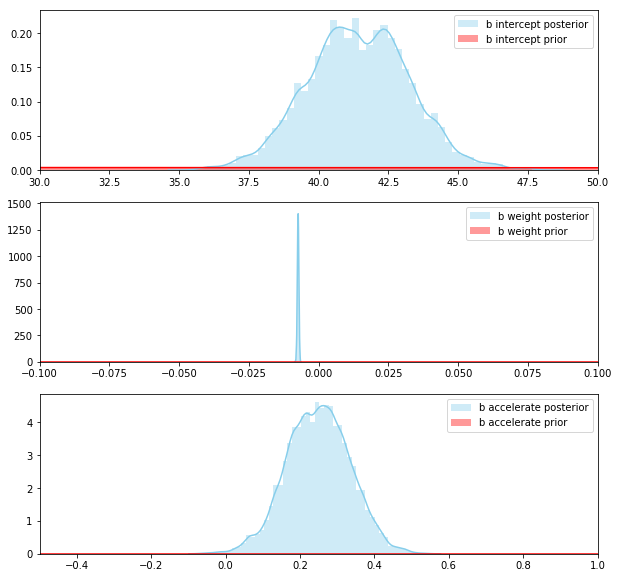

In [6]:
# Plotting the posterior distribution of each variable
b_intercept_prior = np.random.normal(0, np.sqrt(1/0.0001), size=1000)
b_weight_prior = np.random.normal(0, np.sqrt(1/0.0001), size=10000)
b_accelerate_prior = np.random.normal(0, np.sqrt(1/0.0001), size=10000)
b_horsepower_prior = np.random.normal(0, np.sqrt(1/0.0001), size=10000)

multifig, multiax = plt.subplots(3, figsize=(10, 10))

sns.distplot(b_intercept_posterior , color="skyblue", label="b intercept posterior", ax= multiax[0])
sns.distplot(b_intercept_prior, color="red", label="b intercept prior", ax= multiax[0])
multiax[0].set_xlim(30,50)
multiax[0].legend()

sns.distplot(b_weight_posterior , color="skyblue", label="b weight posterior", ax= multiax[1])
sns.distplot(b_weight_prior, color="red", label="b weight prior", ax= multiax[1])
multiax[1].set_xlim(-0.1,0.1)
multiax[1].legend()

sns.distplot(b_accelerate_posterior , color="skyblue", label="b accelerate posterior", ax= multiax[2])
sns.distplot(b_accelerate_prior, color="red", label="b accelerate prior", ax= multiax[2])
multiax[2].set_xlim(-0.5,1)
multiax[2].legend()